In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%cd /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/
%cd gfdl.ncrc4-intel16-prod/pp/ocean_monthly
fs=xr.open_dataset('ocean_monthly.static.nc')
deptho=fs['deptho'][:,:]
lon=fs['geolon']; lat=fs['geolat']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
#print(fs)
%cd av/monthly_5yr/

/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf
/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_monthly
/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_monthly/av/monthly_5yr


In [4]:
yearly = xr.open_mfdataset(['ocean_monthly.2003-2007.01.nc','ocean_monthly.2003-2007.02.nc','ocean_monthly.2003-2007.03.nc',\
                           'ocean_monthly.2003-2007.04.nc','ocean_monthly.2003-2007.05.nc','ocean_monthly.2003-2007.06.nc',\
                           'ocean_monthly.2003-2007.07.nc','ocean_monthly.2003-2007.08.nc','ocean_monthly.2003-2007.09.nc',\
                           'ocean_monthly.2003-2007.10.nc','ocean_monthly.2003-2007.11.nc','ocean_monthly.2003-2007.12.nc'])

spring = xr.open_mfdataset(['ocean_monthly.2003-2007.03.nc','ocean_monthly.2003-2007.04.nc','ocean_monthly.2003-2007.05.nc'])
summer = xr.open_mfdataset(['ocean_monthly.2003-2007.06.nc','ocean_monthly.2003-2007.07.nc','ocean_monthly.2003-2007.08.nc'])
fall   = xr.open_mfdataset(['ocean_monthly.2003-2007.09.nc','ocean_monthly.2003-2007.10.nc','ocean_monthly.2003-2007.11.nc'])
winter = xr.open_mfdataset(['ocean_monthly.2003-2007.12.nc','ocean_monthly.2003-2007.01.nc','ocean_monthly.2003-2007.02.nc'])

fhist  = yearly;
Pressure  = fhist.variables['pso'][:,:,:] #Sea Water Pressure at Sea Water Surface Pa
SST       = fhist.variables['tos'][:,:,:] #tos:long_name = "Sea Surface Temperature" degC
SSS_PSU   = fhist.variables['sos'][:,:,:] #sos:long_name = "Sea Surface Salinity" psu

# Mass flux
mass_in   = fhist.variables['net_massin'][:,:,:]  #all positive
mass_out  = fhist.variables['net_massout'][:,:,:] #all negative
pme_river = mass_in + mass_out #Net Mass flux in kg m-2 s-1, in is positive.
salt_flux_psu = fhist.variables['sfdsi'][:,:,:]*1000.0  #positive salt flux into ocean kg/m2s, ...
#...needs to multiplied by 1000 to convert to psu for consistency with beta

    ## Heat flux components all in W/m2
    #sfc_hflux_from_runoff = fhist.variables['hfrunoffds'][0,:,:] #Heat content (relative to 0C) of liquid+solid runoff into ocean
    #sfc_hflux_coupler     = fhist.variables['net_heat_coupler'][0,:,:] #"Surface ocean heat flux from SW+LW+latent+sensible (via the coupler)"
    #sfc_hflux_pme         = fhist.variables['Heat_PmE'][0,:,:]   #"Heat flux into ocean from mass flux into ocean"
    #frazil_3d_int_z       = fhist.variables['hfsifrazil'][0,:,:] #"Heat Flux into Sea Water due to Frazil Ice Formation"

#The above 4 components should add up to net_surface_heating, 'hfds' diagnostic: 
net_surface_heating   = fhist.variables['hfds'][:,:,:] #"Surface ocean heat flux from SW+LW+latent+sensible+masstransfer+frazil"
#heating_test = sfc_hflux_from_runoff+sfc_hflux_coupler+sfc_hflux_pme+frazil_3d_int_z 
#I checked and heating_test does in fact equal net_surface_heating!


In [5]:
SSS = SA_from_SP(SSS_PSU,Pressure,lon,lat) #absolute salinity g/kg
pot_rho_1 = sigma1(SSS, SST) #potential density referenced to 1000dbar
haline_contraction = beta(SSS, SST, Pressure) #kg/g
salt_transformation_fresh = haline_contraction*SSS*pme_river #*31.0 #last integer is days per month
salt_transformation_salt  = haline_contraction*salt_flux_psu
salt_transformation = salt_transformation_salt + salt_transformation_fresh 

thermal_expansion = alpha(SSS, SST, Pressure)
heat_transformation =  thermal_expansion*net_surface_heating #*days per month?

c_p = 3992.1
SURFACE_heat_transf=-heat_transformation/c_p; #units of kg/(s*m2)
SURFACE_salt_transf=-salt_transformation; #units of kg/(s*m2)
#np.nanmean(heat_transformation)

In [6]:
print('done')
print(np.nanmean(salt_transformation_salt))

done
-8.991855146671481e-09


In [12]:
# lon=np.array(lon)
# lat=np.array(lat)
# lon.shape
# #HOW TO MASK
# topo = lat*0.
# topo[np.isnan(net_surface_heating)]=1
# net_surface_heating[(lat>80)]=np.nan
# #net_surface_heating[lat>70]=0.0

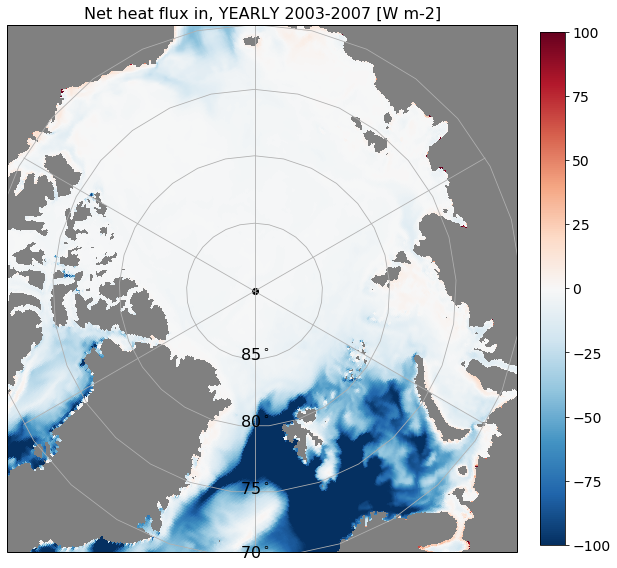

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(net_surface_heating,axis=0),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-100,vmax=100);


cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Net heat flux in, YEARLY 2003-2007 [W m-2]',fontsize=16)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')


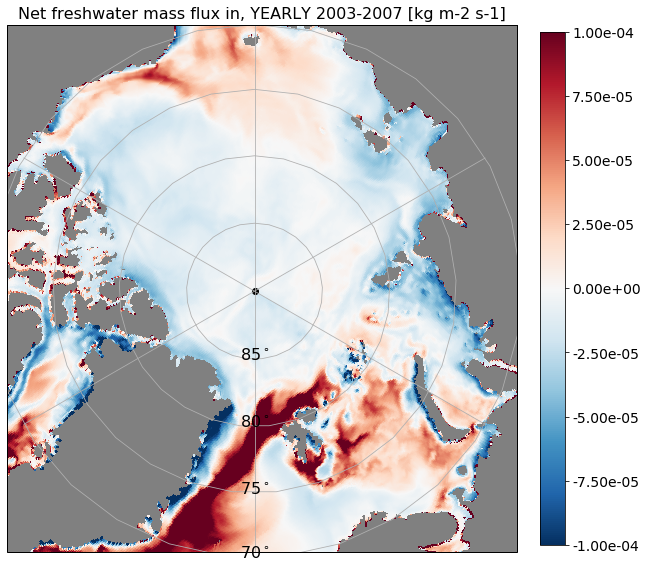

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
plt.pcolormesh(lon, lat,np.nanmean(pme_river,axis=0),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-1e-4,vmax=1.e-4);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Net freshwater mass flux in, YEARLY 2003-2007 [kg m-2 s-1]',fontsize=16)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')



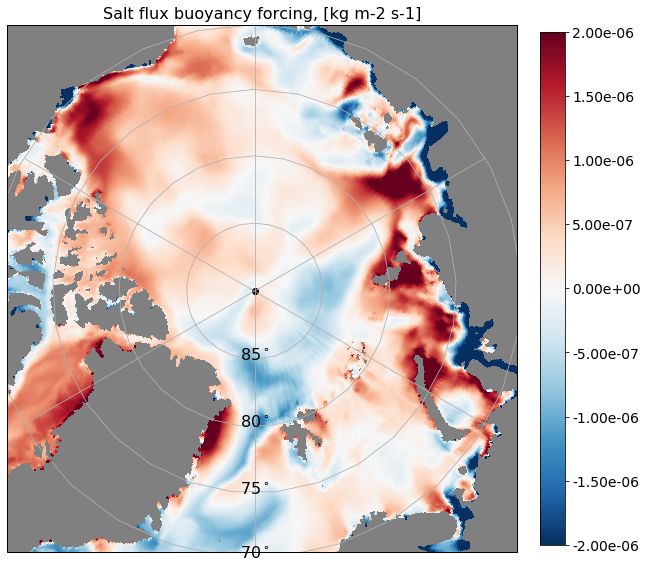

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
plt.pcolormesh(lon, lat,np.nanmean(-salt_transformation_salt,axis=0),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-2e-6,vmax=2.e-6);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Salt flux buoyancy forcing, [kg m-2 s-1]',fontsize=16)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')


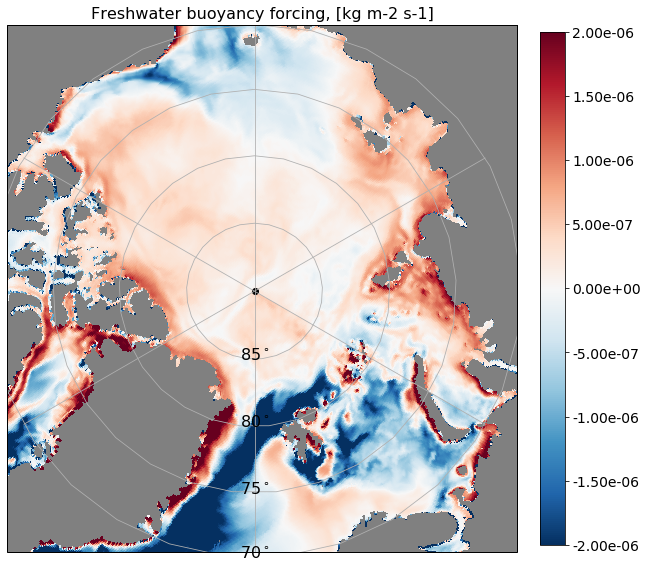

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
plt.pcolormesh(lon, lat,np.nanmean(-salt_transformation_fresh,axis=0),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-2e-6,vmax=2.e-6);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Freshwater buoyancy forcing, [kg m-2 s-1]',fontsize=16)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')


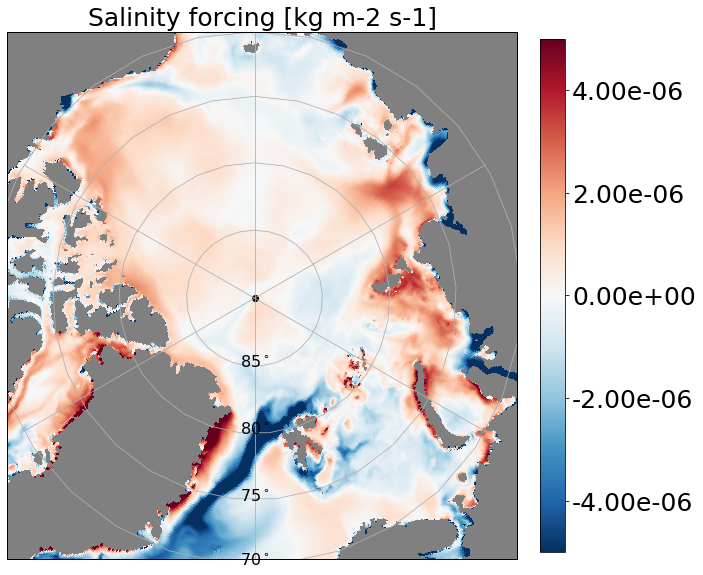

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(SURFACE_salt_transf,axis=0),transform=ccrs.PlateCarree(),vmin=-5e-6,vmax=5e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Salinity forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')


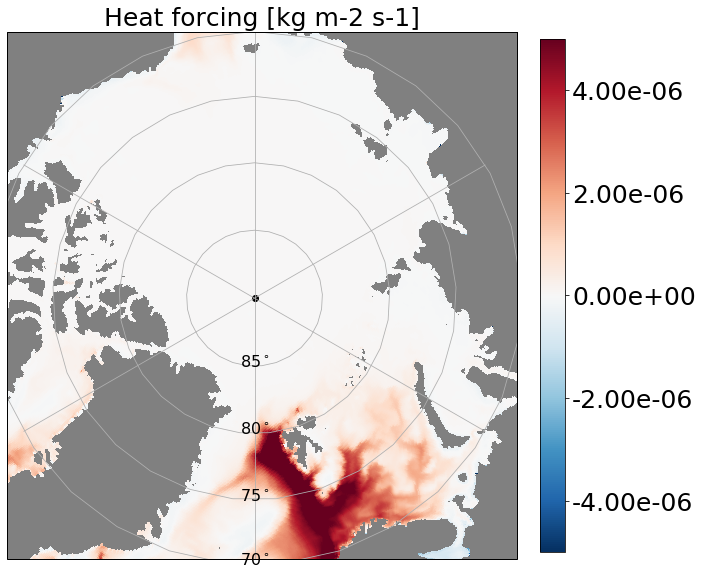

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(SURFACE_heat_transf,axis=0),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-5e-6,vmax=5e-6);
#Positive means dense water in!
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Heat forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')


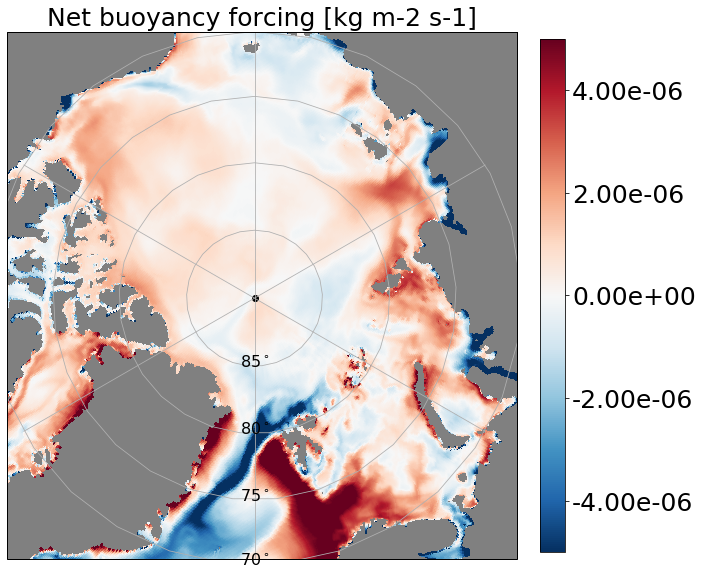

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(SURFACE_heat_transf+SURFACE_salt_transf,axis=0),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-5e-6,vmax=5e-6);
#Positive means dense water in!
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Net buoyancy forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')
